# Dimensionality Reduction using PCA on a large basket of stock returns
## Further details about the math behind this implementation can be found here:
https://www.math.nyu.edu/~avellane/AvellanedaLeeStatArb071108.pdf

In [160]:
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import yfinance as yf

from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import KMeans
from kneed import KneeLocator


import re, seaborn as sns, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
from mpl_toolkits.mplot3d import Axes3D

# Download tickers and set desired model calibration dates and trade dates

In [96]:
import bs4 as bs
import pickle
import requests

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

x=save_sp500_tickers()

for i in range (0,len(x)):
    x[i]=x[i].replace('\n', '')
x.remove('BRK.B')
x.remove('BF.B')
x.remove('ZTS')
x.remove('ZION')
x.remove('ZBH')
x.remove('ZBRA')
x.remove('CEG')
x.remove('ALB')
asset_list=x

In [170]:
#Asset list
lst=asset_list

#dates for model calibration
start_data='2021-09-01'
end_data='2022-09-01'

#dates for trading with algo
start_trade='2022-08-01'
end_trade='2022-09-01'

index_comp='SPY'

# Normalised dataframe of asset returns
### Subtract the mean and divide by the standard deviation for each asset to get normalised return series


In [ ]:
ret_df= pd.DataFrame()
norm_ret_df=pd.DataFrame()
for j in range(0,len(lst)):
    X = yf.download(lst[j], start = start_data, end=end_data)
    X.reset_index(inplace=True)
    X.tail()
    X['Log_Returns'] = np.log(X['Adj Close']) - np.log(X['Adj Close'].shift(1))
    x = X['Log_Returns'].dropna()
    date=X['Date'].drop(labels=0,axis=0)
    date=date.to_frame()

    x_df=x.to_frame()

    b=x_df.rename(columns={'Log_Returns': lst[j]})
    mu=b[lst[j]].mean()
    std=b[lst[j]].std()
    b=b[lst[j]].values
    ret_df[lst[j]]=b
    elements=[]

    for i in range (0,len(b)):
        element=(b[i]-mu)/std
        elements.append(element)
    norm_ret_df[j] = elements
    norm_ret_df=norm_ret_df.rename(columns={j: lst[j]})  


In [204]:
print('Normalised returns dataframe of all assets in basket - SP500 (minus a few that got delisted since the ticker API was updated)')
norm_ret_df.set_index(date['Date'])


Normalised returns dataframe of all assets in basket - SP500 (minus a few that got delisted since the ticker API was updated)


,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-02,0.593918,0.834032,0.612523,-0.239780,0.663199,0.516921,-0.560061,0.435392,0.016296,-0.143282,...,0.747846,0.666115,0.603603,1.034457,1.867829,0.781309,0.352115,0.625735,0.595723,-0.109059
2021-09-03,-0.062792,-0.282850,0.282277,-0.343762,0.311843,0.393311,-0.067318,-0.117161,0.200540,0.206618,...,0.114903,0.091062,-0.054285,-0.432518,-0.426604,-0.850984,-0.430395,-0.625989,-0.198075,-0.147348
2021-09-07,-2.929499,-0.929360,-0.228586,-1.879146,0.369419,-0.254966,-1.585233,-0.874835,-0.211780,-1.588009,...,-0.995407,-0.792772,-1.663767,-0.951840,-0.394724,-1.204818,1.650477,-2.248969,-0.490508,-1.100466
2021-09-08,0.914730,0.199440,0.394625,0.867687,-0.083120,-0.151636,1.083520,0.392029,0.194155,0.828113,...,0.005038,-1.233596,-0.218003,0.228916,-0.318347,-0.529260,-0.303266,1.624366,-0.117076,0.787887
2021-09-09,-0.644236,-0.762515,-0.500016,-2.258859,-0.786789,0.152789,-1.319812,-0.283664,-0.000782,-0.358570,...,0.366226,-0.773279,0.290089,-0.594549,2.890157,-0.292217,-0.133504,-0.075390,-0.344329,-0.472313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-25,0.898413,0.184088,0.332416,0.722572,0.860904,0.637338,-0.116690,1.306595,-0.074519,0.448425,...,2.252158,0.946870,1.364101,-0.057680,1.053782,0.368218,1.030801,0.682588,0.783151,1.361240
2022-08-26,-6.455460,-2.282184,-2.472619,-1.735857,-2.068151,-2.006991,-0.254063,-0.915753,-2.148949,-1.909890,...,-2.133002,-1.946196,-2.410752,-1.075196,-1.630474,-1.819424,-1.140368,-1.254155,-2.245467,-2.500991
2022-08-29,-1.277244,-0.602614,0.013717,-0.430774,-0.106256,-0.505375,0.079303,0.645275,-0.495361,-0.438452,...,0.088522,-0.885969,-0.428201,0.272210,-0.435869,-0.146460,0.096663,0.708409,-0.404543,0.073873


# Correlation matrix
## Instead of finding the eigenvalues and eigenvectors doing SVD step by step as described on page 24 of (A Machine Learning based Pairs Trading Investment Strategy - Simão Moraes Sarmento, Nuno Horta) I will just use sklearn library 

In [205]:
corr_df=norm_ret_df.corr()
corr_df

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WRK,WY,WHR,WMB,WTW,GWW,WYNN,XEL,XYL,YUM
MMM,1.000000,0.580923,0.447249,0.287802,0.322044,0.478782,0.170307,0.295735,0.329256,0.468605,...,0.464633,0.445987,0.520114,0.241813,0.395363,0.497599,0.300084,0.361011,0.569290,0.415684
AOS,0.580923,1.000000,0.459659,0.270855,0.420878,0.579375,0.143860,0.260163,0.489803,0.530827,...,0.473991,0.524457,0.584429,0.251779,0.515981,0.577679,0.360878,0.296687,0.643866,0.486974
ABT,0.447249,0.459659,1.000000,0.402966,0.535313,0.638923,0.118357,0.282437,0.565323,0.605553,...,0.376525,0.494116,0.433177,0.212125,0.518010,0.451345,0.315136,0.338064,0.535481,0.536270
ABBV,0.287802,0.270855,0.402966,1.000000,0.126749,0.290047,0.139520,0.264523,0.128331,0.310537,...,0.183058,0.146551,0.154501,0.233701,0.263578,0.182138,0.047264,0.353542,0.182515,0.215481
ABMD,0.322044,0.420878,0.535313,0.126749,1.000000,0.582035,0.128419,0.222823,0.623777,0.527356,...,0.317241,0.500960,0.429236,0.231827,0.490851,0.337093,0.495280,0.132133,0.549720,0.525226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GWW,0.497599,0.577679,0.451345,0.182138,0.337093,0.497335,0.114244,0.356060,0.422968,0.533370,...,0.354806,0.466121,0.425529,0.302888,0.401221,1.000000,0.247959,0.428017,0.516062,0.393808
WYNN,0.300084,0.360878,0.315136,0.047264,0.495280,0.432089,0.153498,0.252068,0.423395,0.365339,...,0.425719,0.454905,0.364402,0.278372,0.407754,0.247959,1.000000,0.022187,0.388997,0.494271
XEL,0.361011,0.296687,0.338064,0.353542,0.132133,0.308273,0.118607,0.293881,0.134511,0.389441,...,0.210421,0.249414,0.157506,0.279186,0.283296,0.428017,0.022187,1.000000,0.300755,0.267294
XYL,0.569290,0.643866,0.535481,0.182515,0.549720,0.684912,0.162547,0.225208,0.583664,0.609509,...,0.429562,0.468654,0.533714,0.218581,0.566654,0.516062,0.388997,0.300755,1.000000,0.550334


# Number of Features:
## 1) Arbitrarily define 2 features so can visualise data in 2D
## 2) Arbitrarily define 3 features so can visualise data in 3D
## 3) Use proportion of total variance explained 
## 4) As discussed in (https://www.math.nyu.edu/~avellane/AvellanedaLeeStatArb071108.pdf and Bellman R (1966) Dynamic programming.Science153(3731):34–37)  15 factors seems to be an upper bound to avoid "curse of dimensionality" 
### Will explore number of components later on in further detail

## PCA using 2 components

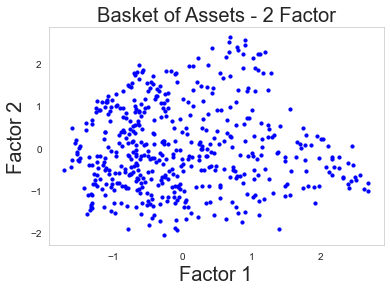

In [206]:
pca = PCA(n_components=2, whiten=True)
beta=pca.fit_transform(norm_ret_df.T)
df_beta=pd.DataFrame(beta)
fig, ax = plt.subplots()
ax.scatter(df_beta[0],df_beta[1], c='blue', s=10)
ax.set_title('Basket of Assets - 2 Factor', fontsize=20)
ax.set_xlabel('Factor 1', fontsize=20)
ax.set_ylabel('Factor 2', fontsize=20)

plt.show()


## PCA using 3 components

/var/folders/mw/jqcldt8d1b123hbd_qm1f0xw0000gn/T/ipykernel_26352/2546358921.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig) # Method 1


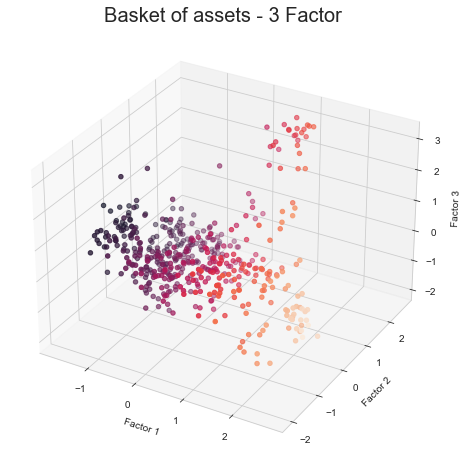

In [198]:
pca = PCA(n_components=3, whiten=True)
beta=pca.fit_transform(norm_ret_df.T)
df_beta=pd.DataFrame(beta)


sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig)


x = df_beta[0]
y = df_beta[1]
z = df_beta[2]


ax.scatter(x, y, z, c=x, marker='o')
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_zlabel('Factor 3')
ax.set_title('Basket of assets - 3 Factor', fontsize=20)

plt.show()

## Number of components using proportion of total variance explained

Percentage of variance explained is >= 80% when n components >= 75


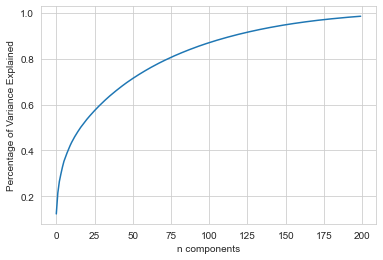

In [196]:
pca_ = PCA(n_components=0.80).fit(norm_ret_df.T)
print('Percentage of variance explained is >= 80% when n components >=',pca_.n_components_)

pca = PCA(n_components=200, whiten=True)
pca.fit_transform(norm_array)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('Percentage of Variance Explained')
plt.grid()




### See later parts for further analysis of how number of PCA components affect trading algo

# Use 3 components as an example and cluster using KMeans

### Optimal number of clusters using elbow method

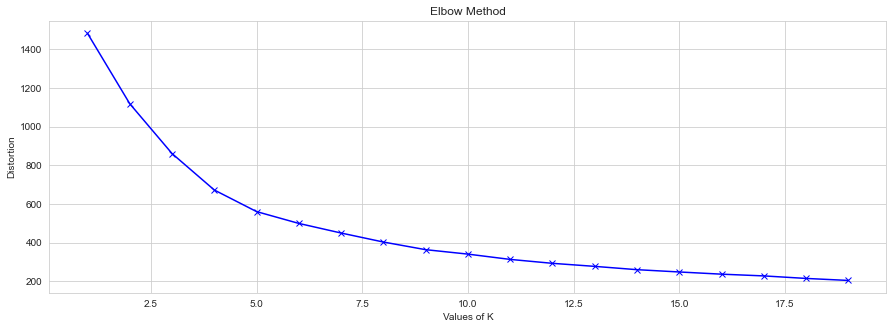

In [164]:

%matplotlib inline

K = range(1,20)
distortions = []
d=[]
#Fit the method
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_beta.values)
    distortions.append(kmeans.inertia_)

#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [166]:
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
k_clusters=kl.elbow
k_clusters

5

In [201]:
data=df_beta.values
model=KMeans(n_clusters=k_clusters) 
model.fit(data) 
label=model.predict(data)
center=model.cluster_centers_

# Visualisation of clusters = 5

/var/folders/mw/jqcldt8d1b123hbd_qm1f0xw0000gn/T/ipykernel_26352/1366732445.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


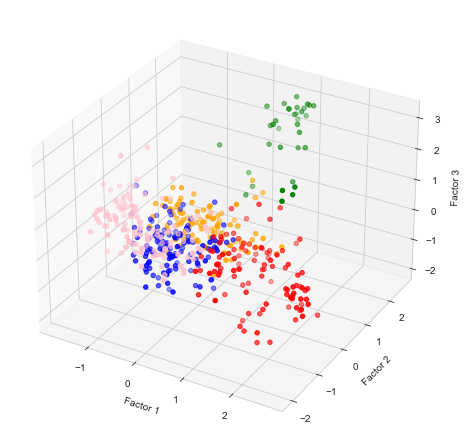

In [202]:
fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig)


ax.scatter(data[label==0, 0], data[label==0, 1],data[label==0, 2], c='red',s=20)
ax.scatter(data[label==1, 0], data[label==1, 1],data[label==1, 2], c='blue', s=20)
ax.scatter(data[label==2, 0], data[label==2, 1],data[label==2, 2], c='green', s=20)
ax.scatter(data[label==3, 0], data[label==3, 1],data[label==3, 2], c='pink', s=20)
ax.scatter(data[label==4, 0], data[label==4, 1],data[label==4, 2], c='orange', s=20)

ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_zlabel('Factor 3')

plt.show()

## Sort dimension reduced data frame based on the cluster each asset belongs to

In [203]:
df_beta['labels']=label
df_beta['labels'] = df_beta['labels'].astype("category")
df_beta=df_beta.set_index(norm_ret_df.T.index)
df_beta.sort_values(by=['labels'])

,0,1,2,labels
PSA,1.175262,-1.210532,0.812494,0
DG,0.544035,-0.905565,-0.233295,0
NRG,0.721132,0.033896,0.346928,0
HII,1.416184,0.533881,1.120746,0
CAH,0.966595,0.704715,-0.547359,0
...,...,...,...,...
LYB,0.222441,2.129301,-0.062406,4
RJF,-0.682649,0.989499,-0.680936,4
RL,-1.046662,0.645652,-0.752313,4
MTB,-0.087925,1.779370,-1.531753,4
